# Wave frequency spectrum for a single grid cell
Frequency (1D) spectrum: [Starting here](https://wikiwaves.org/Ocean-Wave_Spectra) <br>
Directional spectrum: Young (1999) Section 5.5 and Holthuijsen (2007) page 162

**Ordering of entries:**
$(i, j, l, m)$ corresponding to $(x, y, \sigma, \theta)$. But numpy follows a $zyx$ [convention](https://stackoverflow.com/questions/46855793/understanding-axes-in-numpy) rather than $xyz$.

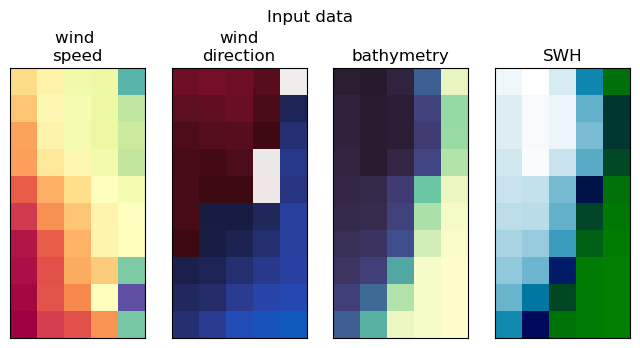

In [1]:
import os
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import xarray as xr
import cmocean.cm as cmo
import swan
from importlib import reload

order = swan.order
l2 = swan.l2
k = swan.k

nx = 10
ny = 10
n = nx * ny

wd = os.path.join('..')
datadir = os.path.join(wd, "data_temp")
u10 = np.load(os.path.join(datadir, "speed.npz"))['array'][:ny, :nx]
theta = np.load(os.path.join(datadir, "direction.npz"))['array'][:ny, :nx]
d = np.load(os.path.join(datadir, "bathymetry.npz"))['array'][:ny, :nx]
swh = np.load(os.path.join(datadir, "sig_waves.npz"))['array'][:ny, :nx]

# redo in case nx or ny out of bounds
ny, nx = u10.shape
n = nx * ny

fig, axs = plt.subplots(1, 4, figsize=(8, 4))
axs[0].imshow(u10, cmap="Spectral_r"), axs[0].set_title('wind \nspeed')
axs[1].imshow(theta, cmap=cmo.balance), axs[1].set_title('wind\ndirection')
axs[2].imshow(d, cmap=cmo.deep), axs[2].set_title('bathymetry')
axs[3].imshow(d, cmap="ocean"), axs[3].set_title('SWH')

for ax in axs:
    ax.set_xticks([]), ax.set_yticks([]);
    
fig.suptitle('Input data');

In [2]:
# set up grid values
nsigma = 20
ntheta = 20

sigmas = np.linspace(0.05, 0.4, nsigma)
thetas = np.linspace(-np.pi, np.pi, ntheta) # always orient so 0 degrees points along x-axis (to coastline)

dsigma = sigmas[1] - sigmas[0]
dtheta = thetas[1] - thetas[0]

# make meshgrids for all the inputs
u10 = u10.ravel(order=order)
theta = theta.ravel(order=order)
d = d.ravel(order=order)

_, _, Depth  = np.meshgrid(thetas, sigmas, d, indexing='ij')
_, _, θm  = np.meshgrid(thetas, sigmas, theta, indexing='ij')
θ, Σ, U10  = np.meshgrid(thetas, sigmas, u10, indexing='ij')

# Make 1d frequency spectrum for grid cell
* JONSWAP spectra: Young (1999) 5.4.1
* JONSWAP for hurricane: Young (1999) 6.5.3.1
* Donelan (1985) Hurricane Spectra: Young (1999) 6.5.3.2

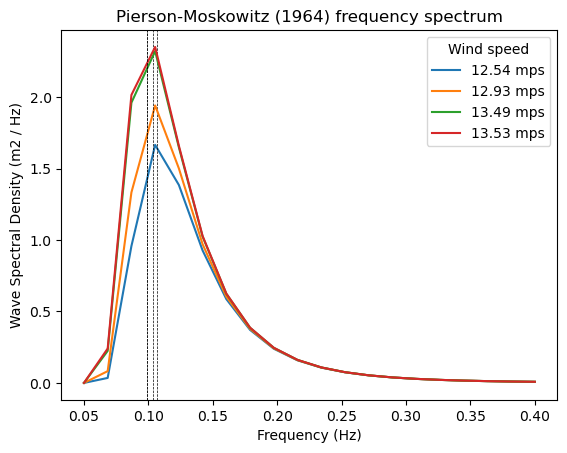

In [9]:
# Pierson Moskowitz 1D spectrum
Ef = swan.spectrum_pm(Σ, U10)
fpeak = swan.peak_frequency_pm(U10) / (2 * np.pi)

fig, ax = plt.subplots()
for i in range(4):
    ax.plot(Σ[0, :, i], Ef[0, :, i], label=f"{u10[i]:.2f} mps")
    ax.axvline(fpeak[0, 0, i], color='k', linewidth=.5, linestyle='dashed');
ax.legend(loc='best', title='Wind speed');
ax.set_title('Pierson-Moskowitz (1964) frequency spectrum');
ax.set_xlabel('Frequency (Hz)');
ax.set_ylabel('Wave Spectral Density (m2 / Hz)');

# Directional spreading
### Young (1999) §4.4.2.3 and §5.5
This directional spreading is often represented in terms of parametric models such as the $\cos^{2s}\theta/2$ model Eq (6.3.23) in Holthuijsen (2007), where $\theta$ is the angle of wave propagation measured relative to the wind direction.  Such a model predicts that the directional spectrum is a maximum in the wind direction and gradually decreases as the angle to the wind direction increases [see Section (5.5)]. Indeed, this model predicts that a small amount of wave energy propagates at angles greater than 90° to the wind.


The directional frequency spectrum defines the distribution of energy with frequency and direction. The spectrum is $E(f,\theta)$ as in $(2.52)$ is represented in terms of the 1D spectrum $E(f)$ as $$E(f,\theta) = E(f)D(f,\theta).$$

The directional spreading function must satisfy the condition
$$ \int D(f, \theta)\text{d}\theta = 1 \qquad (5.59) $$

and $$\langle \eta^2 \rangle = \int\int E(f,\theta)\text{d}f\text{d}\theta. \qquad (2.52)$$

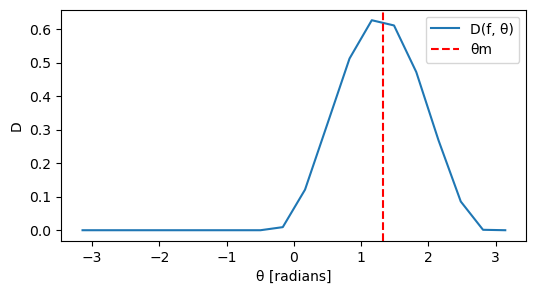

In [4]:
# cos^2 directional spreading
D = swan.cos2_model(θ, θm)
E = Ef * D

plt.figure(figsize=(6, 3))
plt.plot(thetas, D[:, 0, 10], label='D(f, θ)')
plt.axvline(θm[0, 0, 0], color='red', linestyle='dashed', label='θm')
plt.legend();
plt.xlabel('θ [radians]');
plt.ylabel('D');

# Polar heatmap

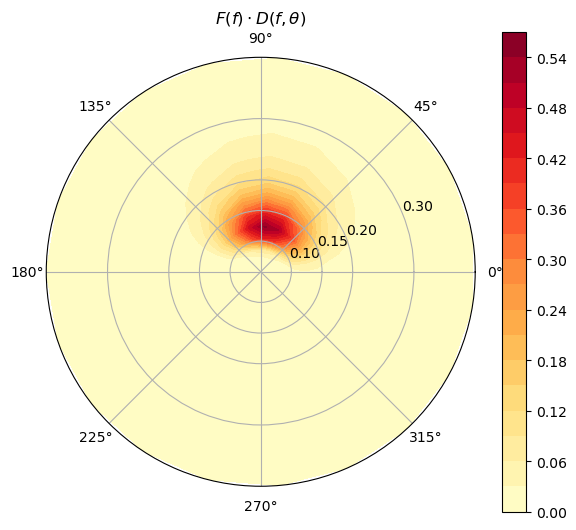

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import gridspec

gs=gridspec.GridSpec(1,1)
gs.update(wspace=0.205, hspace=0.105) 
fig=plt.figure(figsize=(500/72.27,450/72.27))

i = 30
r = Σ[..., i]
theta = θ[..., i]
Z = E[..., i]
#Z = np.where(Z < 1e-3, np.nan, Z)

ax = fig.add_subplot(gs[0,0], projection='polar')
im = ax.contourf(theta, r, Z, 20, cmap="YlOrRd")

ax.set_yticks([0.1, 0.15, 0.2, 0.3])
ax.tick_params(colors='black', axis="y", which='both')
ax.set_title(r"$F(f)\cdot D(f,\theta)$");
plt.colorbar(im);

# Check significant wave height

RMSE: 3.4696


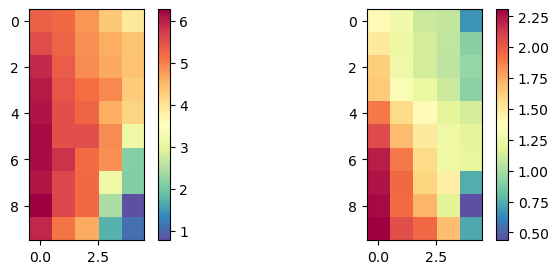

In [19]:
swh0 = swan.significant_wave_height(E, Σ, dsigma, dtheta)
swh0 = swh0.reshape([ny, nx], order='F')
rmse = np.sqrt(np.mean((swh - swh0)**2))
print(f"RMSE: {rmse:.4f}")


fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ax = axs[0]
im = ax.imshow(swh, cmap='Spectral_r')
plt.colorbar(im)
ax = axs[1]
im = ax.imshow(swh0, cmap='Spectral_r')
plt.colorbar(im);

# Numerical solutions in spectral space

# Solution matrix
This needs more thought
* block diagonals
* different directions
* wavenumber - do I just model one at a time or something, why doesn't this change?


## 1. Geographic couplings

Shape:  (5, 20, 50)
λ/d for grid cell 10: 0.03
c/cg for grid cell 10: 2.00


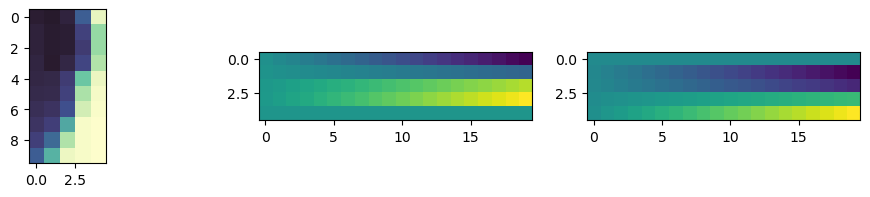

In [10]:
import swan

print("Shape: ", Σ.shape)

λ = swan.λ
k = swan.k
u = swan.u
order = swan.order

stepθ = 1
stepσ = ntheta
stepy = stepσ * nsigma
stepx = stepy * ny

dtheta = 1
dsigma = 1
dy = 1
dx = 1
dt = 0.1

d = d.ravel(order=order)
_, _, D = np.meshgrid(thetas, sigmas, d, indexing='ij')

omega = swan.absolute_frequency(Σ, k, u)
c = swan.phase_speed(k, omega, u)
cg = swan.group_velocity(k, D, omega, u)
cx, cy = swan.spatial_group_velocity(cg, θ)

A_geo = swan.bsbt_matrix(stepx, stepy, cx, cy, dx, dy)
assert np.isclose(np.diag(A_geo, -stepy).sum(), -cy.ravel(order=order)[stepy:].sum() / dy)
assert np.isclose(np.diag(A_geo, -stepx).sum(), -cx.ravel(order=order)[stepx:].sum() / dx)

# inspect grid cell
ji = 10
fig, axs = plt.subplots(1, 3, figsize=(12, 2))
ax = axs[0]
ax.imshow(d.reshape([ny, nx], order=order), cmap=cmo.deep);
ax = axs[1]
ax.imshow(cx[..., ji]);
ax = axs[2]
ax.imshow(cy[..., ji]);

print(f"λ/d for grid cell {ji}: {(λ / d[ji]):.2f}");
print(f"c/cg for grid cell {ji}: {(c / cg)[0, 0, ji]:.2f}");

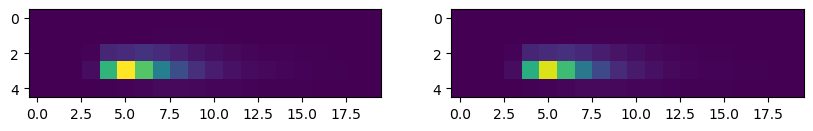

In [11]:
N0 = N.ravel(order=order)
N10 = N0 - dt * (A_geo @ N0) # first do spatial update

ji = 7
fig, axs = plt.subplots(1, 2, figsize=(10, 3))
plota = N0.reshape(ntheta, nsigma, n, order=order)[..., ji]
vmin = plota.min()
vmax = plota.max()
ax = axs[0]
ax.imshow(plota, vmin=vmin, vmax=vmax)
ax = axs[1]
ax.imshow(N10.reshape(ntheta, nsigma, n, order=order)[..., ji], vmin=vmin, vmax=vmax);

In [26]:
ρw = swan.ρw
g = swan.g

E = swan.energy_density(N, Σ)
sse = swan.sse_variance(E)
Etot = swan.sse_variance(E)
hs = swan.significant_wave_height(N, Σ)

In [29]:
reload(swan)

<module 'swan' from '/Users/alison/Documents/DPhil/numerical-wave-models/swan/swan/__init__.py'>

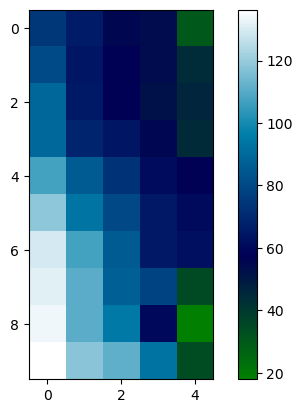

In [27]:
im = plt.imshow(hs, cmap='ocean')
plt.colorbar(im);

## Refraction block matrices

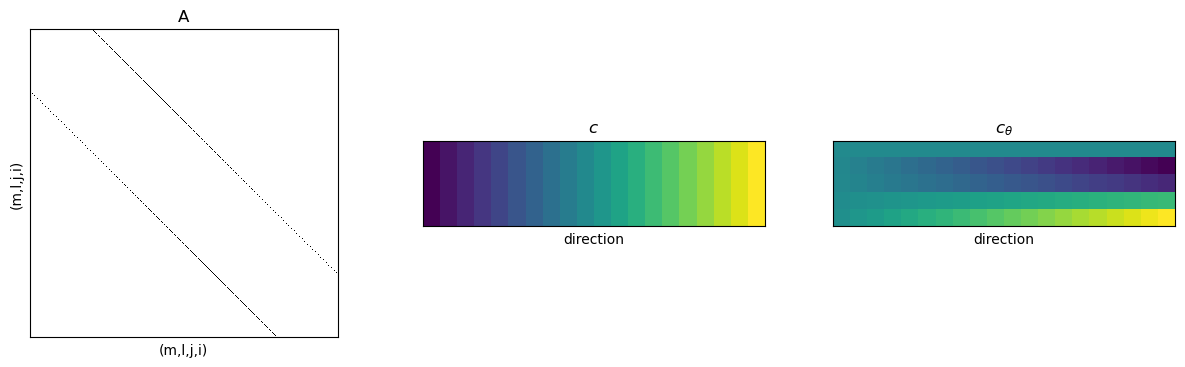

In [280]:
def dcdm_central_diff(direction, stepx, stepy, dx=1, dy=1):
    """Central difference scheme in m-direction using chain rule."""
    θ = direction.ravel(order="F")
    n = len(θ)
    left = np.diag((1 / (2 * dx)) * np.ones(n-stepx), stepx)
    left -= np.diag((1 / (2 * dx)) * np.ones((n-stepx)), -stepx)
    left = left * np.sin(θ)[:, np.newaxis]
    right = np.diag((1 / (2 * dy)) * np.ones(n - stepy), stepy)
    right -= np.diag((1 / (2 * dy)) * np.ones(n - stepy), -stepy)
    right *= np.cos(θ)[:, np.newaxis]
    A = left + right
    return A


A = dcdm_central_diff(thetaij, stepx, stepy)
c_grad = A @ c.ravel(order='F')
c_grad = c_grad.reshape(ntheta, nsigma, ny * nx, order="F")
ctheta = (cg / c) * c_grad

ji = 3 # grid cell number
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].spy(A[:stepx, :stepx])
axs[1].imshow(c[..., ji])
axs[2].imshow(ctheta[..., ji])

axs[0].set_title('A')
axs[1].set_title(r'$c$')
axs[2].set_title(r'$c_\theta$')

axs[0].set_xlabel('(m,l,j,i)')
axs[0].set_ylabel('(m,l,j,i)')

for ax in axs[1:]:
    ax.set_xlabel('frequency')
    ax.set_xlabel('direction')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.label_outer();

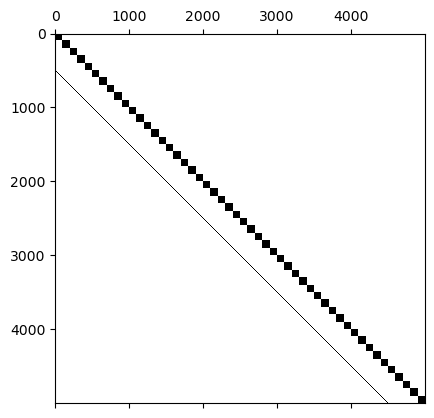

In [296]:
from scipy.linalg import block_diag


def create_blocks(c, step, nu=0.5, axis=-1):
    n = c.shape[axis]
    grid_cells = np.split(c, n, axis=axis)
    blocks = [hybrid_matrix_theta(grid_cell, step, nu) for grid_cell in grid_cells]
    return blocks


def hybrid_matrix_theta(cθ, step, nu=0.5):
    """nu=0: upwind scheme, nu=1: central difference scheme.
    step should be 1 for row-major ('C') ordering in (σ,θ).
    """
    cθ = cθ.ravel(order=order).copy() # numpy arrays are mutable
    counter_clockwise = cθ >= 0
    
    coeff_diag = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    coeff_super = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    left = coeff_diag * np.diag(cθ)
    left += coeff_super * np.diag(cθ[:-step], step)
    
    coeff_diag = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    coeff_sub = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    right = coeff_diag * np.diag(cθ[step:], -step)
    right += coeff_sub * np.diag(cθ)
    
    A = left - right
    return A


blocks = create_blocks(ctheta, stepθ)
blocks = [0.1 + block for block in blocks] # adding shift to visualise blocks
A = block_diag(*blocks)
A += A_geo

plt.spy(A);

# Old (for ref)

In [137]:
N = F.ravel(order='F')

stepθ = 1
stepσ = ntheta
stepy = stepσ * nsigma
stepx = stepy * ny

cg = np.ones(len(N)) # make this in a minute
cθ = np.ones(len(N))
cσ = np.ones(len(N))

print(ntheta, nsigma, ny, nx)
print(stepθ, stepσ, stepy, stepx)

4 4 5 4
1 4 16 80


(320, 320)


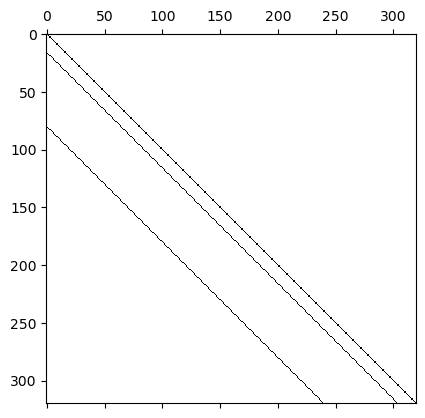

In [139]:
def bsbt_matrix(nx, ny, cx=cg, cy=cg, dx=1, dy=1):
    """Construct BSBT scheme matrix."""
    A = np.diag((cx.ravel(order='F') / dx) + (cy.ravel() / dy))
    A -= np.diag((cx.ravel(order='F')[nx:] / dx), -nx)
    A -= np.diag((cy.ravel(order='F')[ny:] / dy), -ny)
    return A


A_geo = bsbt_matrix(stepx, stepy) 
print(A_geo.shape)
plt.spy(A_geo)

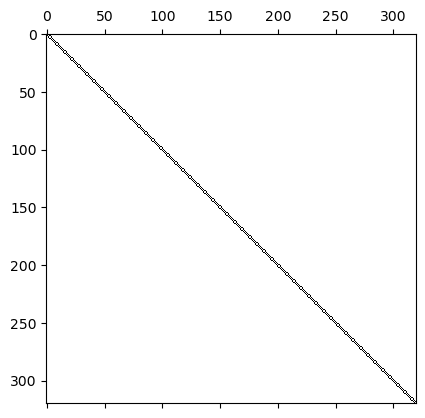

In [140]:
def hybrid_matrix_theta(cθ, step, nu=0.5):
    """nu=0: upwind scheme, nu=1: central difference scheme.
    step should be 1 for row-major ('C') ordering in (σ,θ).
    """
    cθ = cθ.ravel(order='C').copy() # numpy arrays are mutable
    counter_clockwise = cθ >= 0
    
    coeff_diag = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    coeff_super = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    left = coeff_diag * np.diag(cθ)
    left += coeff_super * np.diag(cθ[:-step], step)
    
    coeff_diag = np.where(counter_clockwise, 0.5 * nu, 1 - 0.5 * nu)
    coeff_sub = np.where(counter_clockwise, 1 - 0.5 * nu, 0.5 * nu)
    right = coeff_diag * np.diag(cθ[step:], -step)
    right += coeff_sub * np.diag(cθ)
    
    A = left - right
    return A

A_theta = hybrid_matrix_theta(cθ, stepθ, nu=0.5)
plt.spy(A_theta)

In [ ]:
import numpy as np
custom_steps = np.array([1, 2, 1, 2, 1, 2, 1, 2])  # Define an array of custom step sizes
result = np.arange(0, 10, custom_steps)  # Use the custom step sizes with numpy.arange()
print(result)

In [149]:
mask = np.ones(len(N))
mask[0:stepθ] = 0
mask[stepσ:stepσ + stepθ] = 0

In [153]:
np.linspace(0, len(N), np.array([stepθ, stepσ]))

TypeError: only integer scalar arrays can be converted to a scalar index

In [150]:
mask

array([0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

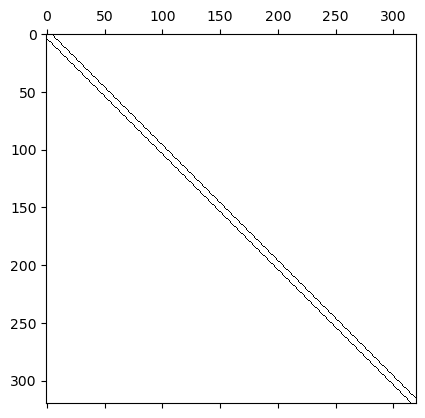

In [141]:
def hybrid_matrix_sigma(cσ, step, mu=0.5):
    """mu=0: upwind scheme, nu=1: central difference scheme.
    step should be 1 for row-major ('C') ordering in (σ,θ).
    """
    cσ = cσ.ravel(order='C').copy() # numpy arrays are mutable
    higher = cσ >= 0
    
    coeff_diag = np.where(higher, 1 - 0.5 * mu, 0.5 * mu)
    coeff_super = np.where(higher, 0.5 * mu, 1 - 0.5 * mu)
    left = coeff_diag * np.diag(cσ)
    left += coeff_super * np.diag(cσ[:-step], step)
    
    coeff_diag = np.where(higher, 0.5 * mu, 1 - 0.5 * mu)
    coeff_sub = np.where(higher, 1 - 0.5 * mu, 0.5 * mu)
    right = coeff_diag * np.diag(cσ[step:], -step)
    right += coeff_diag * np.diag(cσ)
    
    A = left - right
    return A


A_sigma = hybrid_matrix_theta(cθ, stepσ, nu=0.5)
plt.spy(A_sigma)

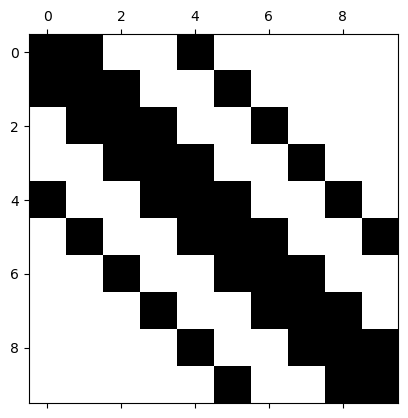

In [144]:
plt.spy((A_geo + A_sigma + A_theta)[:10, :10])

In [146]:
ntheta, nsigma

(4, 4)